## EDA

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
pip install plotly-express wordcloud plotly-geo==1.0.0 

Note: you may need to restart the kernel to use updated packages.


In [3]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
# conf = spark.sparkContext._conf.setAll()

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [4]:
# # Import Data
# dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
# business = spark.read.json(dataDir + "/sample_business")
# checkin = spark.read.json(dataDir + "/sample_checkin")
# review = spark.read.json(dataDir + "/sample_review")
# tip = spark.read.json(dataDir + "/sample_tip")
# user = spark.read.json(dataDir + "/sample_user")

In [5]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-kaggleAPI/"
business = spark.read.json(dataDir + "yelp_academic_dataset_business.json")
checkin = spark.read.json(dataDir + "yelp_academic_dataset_checkin.json")
review = spark.read.json(dataDir + "yelp_academic_dataset_review.json")
tip = spark.read.json(dataDir + "yelp_academic_dataset_tip.json")
user = spark.read.json(dataDir + "yelp_academic_dataset_user.json")

23/08/16 16:14:58 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
fips = spark.read.format("csv").option("header","true").load("gs://msca-bdp-student-gcs/group2/fips.csv")

## Businesses

In [7]:
business.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [8]:
business.take(1)

[Row(address='1616 Chapala St, Ste 2', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking=None, BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards=None, BusinessParking=None, ByAppointmentOnly='True', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2=None, RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='Pns2l4eNsfO8kk83dixA6A', categories='Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical,

In [9]:
from pyspark.sql.functions import isnan, when, count
business.select([count(when(business[c].isNull(), c)).alias(c) for c in business.columns]).show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     13744|          0|       103|   0|23223|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [10]:
# 1. How many unique business?
business.select('business_id').distinct().count()

150346

### What are the top 10 categories out of all?

To do this, we have to split categories from each observation, since one business can have multiple categories at the same time.

In [11]:
business.select('categories').distinct().show(5, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------+
|Restaurants, Chicken Wings, Sandwiches, Pizza                                                                            |
|Used, Vintage & Consignment, Fashion, Shopping                                                                           |
|Fences & Gates, Painters, Handyman, Contractors, Home Services, Shopping, Kitchen & Bath, Plumbing, Tiling, Home & Garden|
|Active Life, Brazilian Jiu-jitsu, Martial Arts, Fitness & Instruction                                                    |
|Parks, Active Life, Dog Parks                                                                                            |
+-------

In [12]:
from pyspark.sql.functions import explode, split
business1 = business.withColumn('categories_split', explode(split('categories', ', ')))

In [13]:
df1 = business1.groupby('categories_split').count().orderBy('count', ascending = [0])

In [14]:
df1.show(10, truncate = False)

+----------------+-----+
|categories_split|count|
+----------------+-----+
|Restaurants     |52268|
|Food            |27781|
|Shopping        |24395|
|Home Services   |14356|
|Beauty & Spas   |14292|
|Nightlife       |12281|
|Health & Medical|11890|
|Local Services  |11198|
|Bars            |11065|
|Automotive      |10773|
+----------------+-----+
only showing top 10 rows



In [15]:
pdf1 = df1.toPandas()
pdf1.head()

,categories_split,count
0,Restaurants,52268
1,Food,27781
2,Shopping,24395
3,Home Services,14356
4,Beauty & Spas,14292


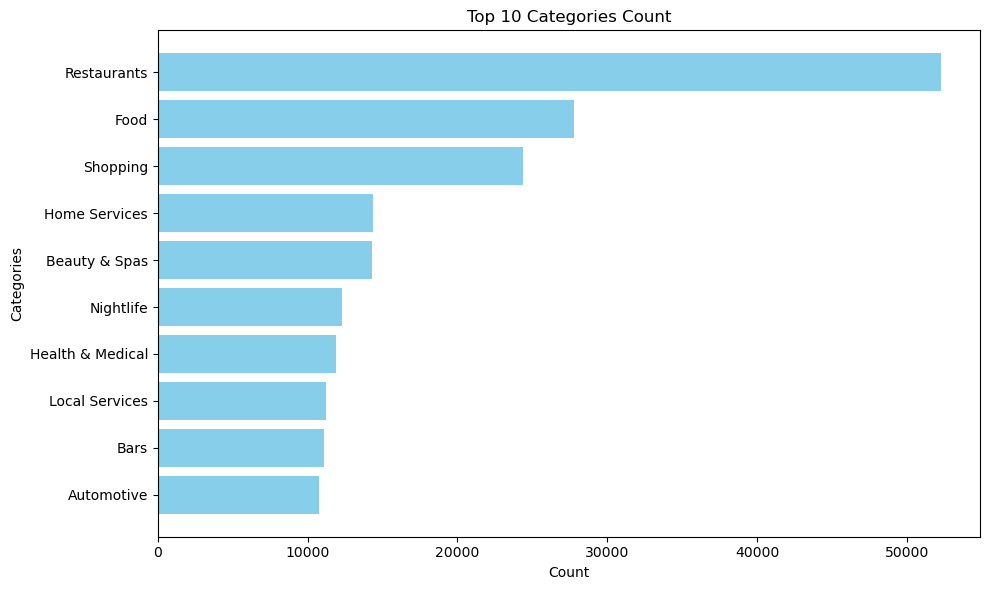

In [16]:
top_10_categories = pdf1.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['categories_split'], top_10_categories['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Top 10 Categories Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

### Where are businesses located?

We did this by grouping them by states and create a interactive map using Plotly.

In [17]:
df2 = business.groupby('state').count().orderBy('count', ascending =[0])

In [18]:
fips.show()

+-----+----+
|state|fips|
+-----+----+
|   AL|  01|
|   AK|  02|
|   AZ|  04|
|   AR|  05|
|   CA|  06|
|   CO|  08|
|   CT|  09|
|   DE|  10|
|   FL|  12|
|   GA|  13|
|   HI|  15|
|   ID|  16|
|   IL|  17|
|   IN|  18|
|   IA|  19|
|   KS|  20|
|   KY|  21|
|   LA|  22|
|   ME|  23|
|   MD|  24|
+-----+----+
only showing top 20 rows



In [19]:
df2 = df2.join(fips, df2.state==fips.state, 'inner').select(df2.state, 'fips', 'count')

In [20]:
df2.show()

+-----+----+-----+
|state|fips|count|
+-----+----+-----+
|   AZ|  04| 9912|
|   LA|  22| 9924|
|   NJ|  34| 8536|
|   NV|  32| 7715|
|   MI|  26|    1|
|   ID|  16| 4467|
|   CA|  06| 5203|
|   VT|  50|    1|
|   NC|  37|    1|
|   MT|  30|    1|
|   DE|  10| 2265|
|   MO|  29|10913|
|   IL|  17| 2145|
|   WA|  53|    2|
|   IN|  18|11247|
|   TN|  47|12056|
|   PA|  42|34039|
|   SD|  46|    1|
|   FL|  12|26330|
|   CO|  08|    3|
+-----+----+-----+
only showing top 20 rows



In [23]:
pdf2 = df2.toPandas()
pdf2.head()

,state,fips,count
0,AZ,04,9912
1,LA,22,9924
2,NJ,34,8536
3,NV,32,7715
4,MI,26,1


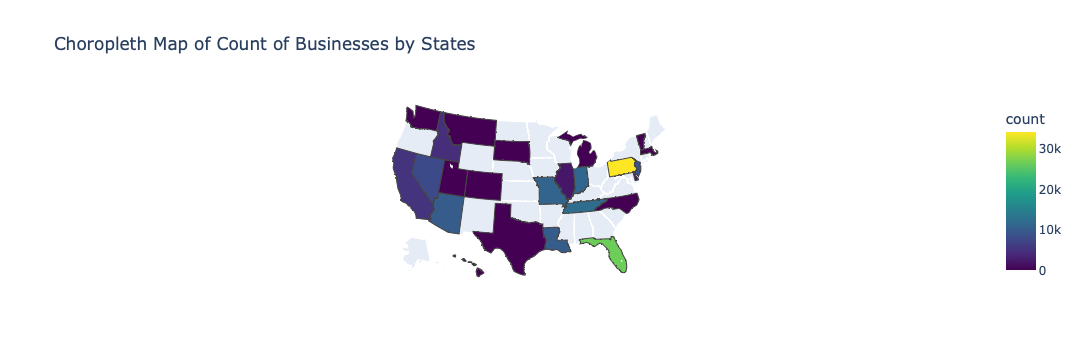

In [25]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"
fig = px.choropleth(
    pdf2,
    locations="state",  # Column containing state abbreviations
    locationmode="USA-states",       # Use USA state-level mapping
    color="count",                   # Column to determine the color intensity
    hover_name="state", # Tooltip text
    scope="usa",                     # Map scope to USA
    color_continuous_scale="Viridis", # Color scale
    title="Choropleth Map of Count of Businesses by States"
)

# Show the map
fig.show()

Majority of our businesses are found in the states of Pennsylvania and Florida.

## Businesses and Ratings

### How are number of ratings for businesses distributed?

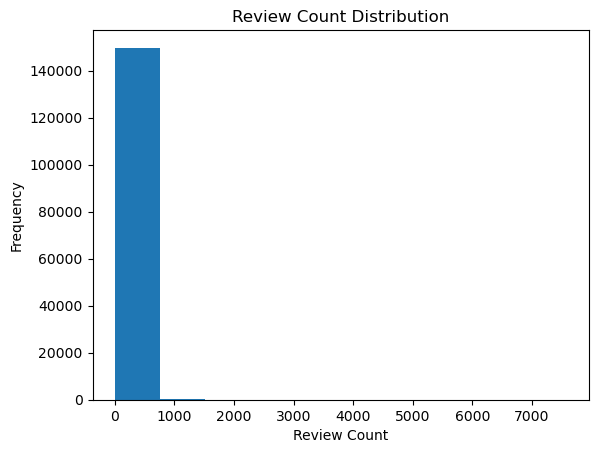

In [23]:
# Review Count Distribution
review_count_dist = business.select("review_count").rdd.flatMap(lambda x: x).histogram(10)
counts = review_count_dist[1]
bins = review_count_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Review Count Distribution')
plt.show()

Majority of the businesses receive less than 1000 reviews. However, we can see there are some outliers with up to 7000+ reviews.

### Which businesses have more reviews?

In [24]:
max_review_count = business.selectExpr("max(review_count) as max_review_count").collect()[0]["max_review_count"]
min_review_count = business.selectExpr("min(review_count) as min_review_count").collect()[0]["min_review_count"]
avg_review_count = business.selectExpr("avg(review_count) as avg_review_count").collect()[0]["avg_review_count"]
median_review_count = business.approxQuantile("review_count", [0.5], 0.01)[0]

print(f"Max Review Count: {max_review_count}")
print(f"Min Review Count: {min_review_count}")
print(f"Avg Review Count: {avg_review_count}")
print(f"Median Review Count: {median_review_count}")

Max Review Count: 7568
Min Review Count: 5
Avg Review Count: 44.86656113232144
Median Review Count: 14.0


In [25]:
# Top 10 Review Count Business
from pyspark.sql.functions import col, expr, desc
df3 = business.orderBy(desc("review_count")).limit(10).select("name", "review_count", 'stars')

In [26]:
df3.show(truncate = False)

+----------------------------------+------------+-----+
|name                              |review_count|stars|
+----------------------------------+------------+-----+
|Acme Oyster House                 |7568        |4.0  |
|Oceana Grill                      |7400        |4.0  |
|Hattie B’s Hot Chicken - Nashville|6093        |4.5  |
|Reading Terminal Market           |5721        |4.5  |
|Ruby Slipper - New Orleans        |5193        |4.5  |
|Mother's Restaurant               |5185        |3.5  |
|Royal House                       |5070        |4.0  |
|Commander's Palace                |4876        |4.5  |
|Luke                              |4554        |4.0  |
|Cochon                            |4421        |4.0  |
+----------------------------------+------------+-----+



In [27]:
pdf3 = df3.toPandas()
pdf3.head()

,name,review_count,stars
0,Acme Oyster House,7568,4.0
1,Oceana Grill,7400,4.0
2,Hattie B’s Hot Chicken - Nashville,6093,4.5
3,Reading Terminal Market,5721,4.5
4,Ruby Slipper - New Orleans,5193,4.5


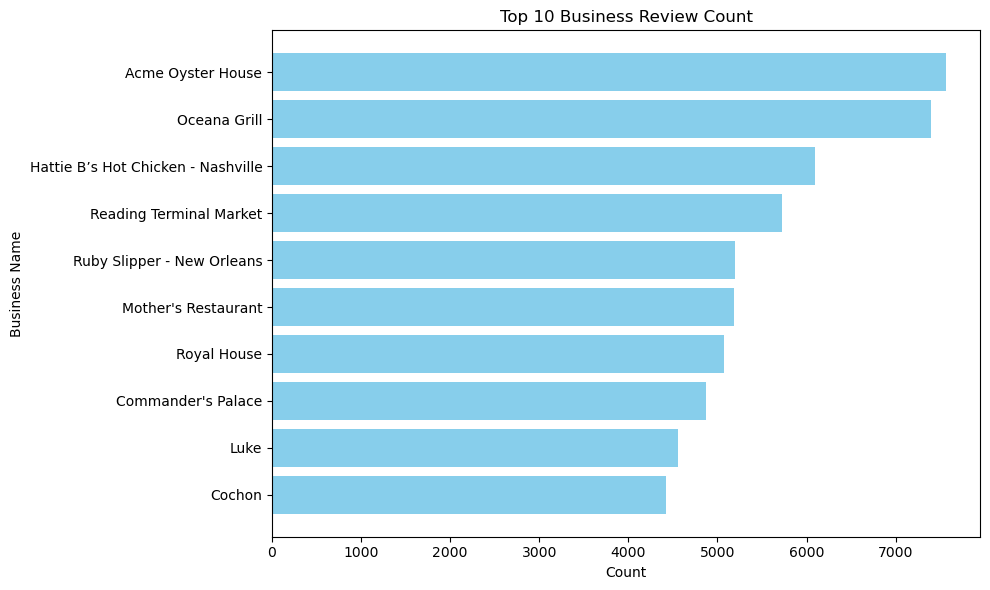

In [28]:
top_10_categories = pdf3.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['name'], top_10_categories['review_count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Business Name')
plt.title('Top 10 Business Review Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

Top 10 businesses can receive more than 4000 reviews each.

### How are ratings distributed?

In [29]:
max_rating = business.selectExpr("max(stars) as max_rating").collect()[0]["max_rating"]
min_rating = business.selectExpr("min(stars) as min_rating").collect()[0]["min_rating"]
avg_rating = business.selectExpr("avg(stars) as avg_rating").collect()[0]["avg_rating"]

print(f"Max Rating: {max_rating}")
print(f"Min Rating: {min_rating}")
print(f"Avg Rating: {avg_rating}")

Max Rating: 5.0
Min Rating: 1.0
Avg Rating: 3.5967235576603303


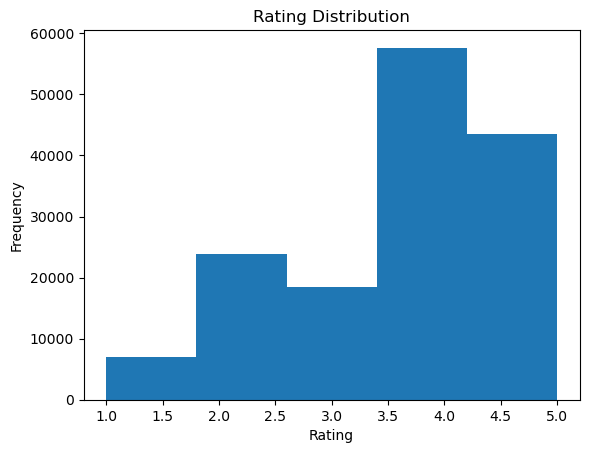

In [30]:
rating_dist = business.select("stars").rdd.flatMap(lambda x: x).histogram(5)  
counts = rating_dist[1]
bins = rating_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

Majority of ratings are above 3.5 points, meaning more likely users will leave good comments than bad ones.

In [31]:
top_ten_ratings = business.orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

+------------------------------------------+-----+------------+
|name                                      |stars|review_count|
+------------------------------------------+-----+------------+
|Trax Customs                              |5.0  |5           |
|Bebe's Nails                              |5.0  |9           |
|The Wanamaker Eagle                       |5.0  |6           |
|LUCEO Skin + Beauty                       |5.0  |5           |
|Good Honest Mechanic                      |5.0  |7           |
|Donna Marshall - RE/MAX Point Realty      |5.0  |5           |
|CubeSmart Self Storage                    |5.0  |5           |
|BestDentist4Kids - Philadelphia           |5.0  |6           |
|Douglas Cicileo Tree and Arborist Services|5.0  |7           |
|Tina's African Hair Braiding              |5.0  |5           |
+------------------------------------------+-----+------------+



Comparing the top restaurant lists given by highest rating versus highest review counts resulted in the observation that the two criteria don’t appear to show strong correlation to each other.

In [32]:
# So check the stars rank when review_count above average
top_ten_ratings = business.where(col('review_count') >= avg_review_count).orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

+------------------------------------+-----+------------+
|name                                |stars|review_count|
+------------------------------------+-----+------------+
|Blue Blossoms                       |5.0  |48          |
|Big Blue Q of Tahoe                 |5.0  |51          |
|The Hill Cigar Company              |5.0  |55          |
|Fly-N-High Waverunners & Parasailing|5.0  |74          |
|The Wax Pot Body Waxing             |5.0  |59          |
|Philly Bloke                        |5.0  |69          |
|Details Carpet Solutions            |5.0  |45          |
|Spa Sudeva                          |5.0  |144         |
|Aperitivo                           |5.0  |47          |
|Tucson Mineral and Gem World        |5.0  |51          |
+------------------------------------+-----+------------+



In [33]:
high_rating_city = business.filter(col("stars") >= 4.5).groupBy("city").count().orderBy(desc("count")).first()
low_rating_city = business.filter(col("stars") <= 2.5).groupBy("city").count().orderBy(desc("count")).first()

print(f"City with most high-rated businesses: {high_rating_city['city']}, Count: {high_rating_city['count']}")
print(f"City with most low-rated businesses: {low_rating_city['city']}, Count: {low_rating_city['count']}")

City with most high-rated businesses: Philadelphia, Count: 4297
City with most low-rated businesses: Philadelphia, Count: 2788


In [34]:
checkin.show()
checkin.select([count(when(checkin[c].isNull(), c)).alias(c) for c in checkin.columns]).show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
|--8IbOsAAxjKRoYsB...|2015-06-06 01:03:...|
|--9osgUCSDUWUkoTL...|2015-06-13 02:00:...|
|--ARBQr1WMsTWiwOK...|2014-12-12 00:44:...|
|--FWWsIwxRwuw9vIM...|2010-09-11 16:28:...|
|--FcbSxK1AoEtEAxO...|2017-08-18 19:43:...|
|--LC8cIrALInl2vyo...|2017-01-12 19:10:...|
|--MbOh2O1pATkXa7x...|2013-04-21 01:52:...|
|--N9yp3ZWqQIm7DqK...|2012-10-06 20:46:...|
|--O3ip9NpXTKD4oBS...|2010-04-17 21:07:...|
|--OS_I7dnABrXvRCC...| 2018-05-11 18:23:36|
|--S43ruInmIsGrnnk...|2010-08-29 01:17:...|
|--SJXpAa0E-GCp2sm...|2014-04-06 22:23:...|
|--Sd93OFWITqDHifM...|2013-01-09 17:42:...|
|--ZVrH2X2QXBFdCil...|2010-08-12 18:21:...|
|--ZWv8kGlM2YL58uK...|2010-10-13

+-----------+----+
|business_id|date|
+-----------+----+
|          0|   0|
+-----------+----+



In [35]:
review.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [36]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [37]:
review.select([count(when(review[c].isNull(), c)).alias(c) for c in review.columns]).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [38]:
# Top 10 users in Yelp and the quality of their reviews
review.groupby('user_id').agg({'review_id': 'count', 'useful': 'sum', 'cool': 'sum', 'funny': 'sum'}).orderBy('count(review_id)', ascending = [0]).show()

+--------------------+----------------+---------+-----------+----------+
|             user_id|count(review_id)|sum(cool)|sum(useful)|sum(funny)|
+--------------------+----------------+---------+-----------+----------+
|_BcWyKQL16ndpBdgg...|            3048|     6373|      11043|      3344|
|Xw7ZjaGfr0WNVt6s_...|            1840|     7225|      12011|      5034|
|0Igx-a1wAstiBDerG...|            1747|     5022|       8254|      3169|
|-G7Zkl1wIWBBmD0KR...|            1682|    26749|      34694|     17774|
|ET8n-r7glWYqZhuR6...|            1653|    12585|      19474|      5631|
|bYENop4BuQepBjM1-...|            1578|     8600|      11680|      4168|
|1HM81n6n4iPIFU5d2...|            1554|     3198|       6138|      2241|
|fr1Hz2acAb3OaL3l6...|            1447|    13145|      15356|      4634|
|wXdbkFZsfDR7utJvb...|            1396|     3057|       5715|       418|
|Um5bfs5DH6eizgjH3...|            1391|     3424|       4645|      1975|
|qjfMBIZpQT9DDtw_B...|            1324|     7312|  

In [39]:
tip.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|ld0AperBXk1h6Ubqm...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [40]:
user.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         

In [41]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [42]:
# Total unique users
user.select('user_id').distinct().count()

1987897

In [43]:
user.createOrReplaceTempView("user_table")

In [44]:
res = spark.sql('SELECT (LENGTH(friends) - LENGTH(REPLACE(friends,",","")) + 1) AS `Number of Friends` from user_table')

In [45]:
res.show()

+-----------------+
|Number of Friends|
+-----------------+
|            14995|
|             4646|
|              381|
|              131|
|               27|
|             5843|
|               23|
|               82|
|              488|
|               64|
|              241|
|              356|
|              154|
|               64|
|               14|
|              187|
|               13|
|               84|
|              487|
|              133|
+-----------------+
only showing top 20 rows



In [46]:
# The popularity of Yelp: # of users
# Change the format of yelping_since
from pyspark.sql.functions import to_timestamp, date_format
user_new = user.withColumn('yelping_since', to_timestamp(user['yelping_since'], 'yyyy-MM-dd hh:mm:ss a'))
user_new = user.withColumn('yelping_month', date_format('yelping_since', 'yyyy-MM'))

In [47]:
user_new.show(3)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|yelping_month|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+------------

In [48]:
from pyspark.sql.functions import date_sub, current_date, date_format
df_ts = df_all.where(col('Date') >= date_sub(current_date(), 365 * 3)) \
              .groupBy(date_format('Date', 'yyyy-MM').alias('Time')) \
              .count() \
              .orderBy('Time', ascending = [1])

NameError: name 'df_all' is not defined

In [ ]:
from pyspark.sql.functions import date_sub, current_date, date_format

df4 = user_new.groupBy('yelping_month').agg({'user_id': 'count'}).orderBy('yelping_month', ascending = [1])

In [ ]:
df4.show()

In [ ]:
pdf4 = df4.toPandas()

In [ ]:
pdf4.plot(kind = 'line', x = 'yelping_month', figsize = (10, 6))

In [ ]:
# pip install wordcloud

### tips

In [ ]:
tip_lis = tip.sample(0.01).select('text').collect()

In [ ]:
tip_lis = ' '.join([tip_lis[i][0] for i in range(len(tip_lis))])

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(tip_lis)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [ ]:
tip.groupBy('business_id').count().orderBy('count',ascending=False).show()

In [ ]:
review.groupBy('business_id').count().orderBy('count',ascending=False).show()